In [11]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas  as pd
import numpy as np
from enum import Enum

In [54]:
class Datasets(Enum):
    PPI = 1
    KKI = 2
    CORA = 3
    TERR = 4
    
DATASET_USED = Datasets.PPI

def get_ppi_dataset(emb_file):
    """
    returns a dataframe with embeddings and labels
    """
    # first row has the # of nodes and features
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    lines = [line for line in open(LABELS_FILE).read().splitlines()]
    node_ids = [int(line.split()[0]) for line in lines]
    labels = [list(map(int, line.split()[1:])) for line in lines]
    input_df = pd.DataFrame({'node_id': node_ids, 'labels': labels})
    
    result_df = pd.merge(emb_df, input_df, on='node_id', how='inner')
    
    return result_df

def get_kki_dataset(emb_file):
    """
    returns a dataframe with embeddings and labels
    """
    # first row has the # of nodes and features
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    labels = [[int(line)] for line in open(LABELS_FILE).read().splitlines()]
    node_ids = [x for x in range(1, len(labels)+1)]
    input_df = pd.DataFrame({'node_id': node_ids, 'labels': labels})
    
    result_df = pd.merge(emb_df, input_df, on='node_id', how='inner')
    
    return result_df

# Used as well for terroristrel graph
def get_cora_dataset(emb_file):
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    input_df = pd.read_csv(LABELS_FILE, header=None, names=["node_id", "label"])
    input_df_grouped = input_df.groupby(by=['node_id'])['label'].apply(list).reset_index(name ='labels')
    result_df = pd.merge(emb_df, input_df_grouped, on='node_id', how='inner')
    
    return result_df

if DATASET_USED == Datasets.TERR:
    FILE_NAME = "TerroristRel"
    LABELS_FILE = "../graph/TerroristRel/TerroristRel.node_labels"
    emb_file = "../emb/TerroristRel.emb"
    INPUT_FILE = "../graph/TerroristRel/TerroristRel.edges"
    df = get_cora_dataset(emb_file)
if DATASET_USED == Datasets.CORA:
    FILE_NAME = "cora"
    LABELS_FILE = "../graph/cora/cora.node_labels"
    emb_file = "../emb/cora.emb"
    INPUT_FILE = "../graph/cora/cora.edges"
    df = get_cora_dataset(emb_file)
elif DATASET_USED == Datasets.PPI:
    FILE_NAME = "ppi"
    LABELS_FILE = "../graph/PPI/ppi_labels.txt"
    emb_file = "../emb/ppi.emb"
    INPUT_FILE = "../graph/PPI/ppi.edgelist"
    df = get_ppi_dataset(emb_file)
elif DATASET_USED == Datasets.KKI:
    FILE_NAME = "KKI"
    LABELS_FILE = "../graph/KKI/KKI.node_labels"
    emb_file = "../emb/kki.emb"
    INPUT_FILE = "../graph/KKI/KKI.edges"
    df = get_kki_dataset(emb_file)
    
df.head()

,node_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f120,f121,f122,f123,f124,f125,f126,f127,f128,labels
0,3631,-0.236860,-0.075137,0.084158,0.080069,0.323141,-0.221970,0.392479,-0.146619,0.374089,...,0.312769,0.087306,-0.059808,-0.050686,-0.132301,-0.074183,-0.225803,0.215725,0.501792,"[10, 25, 35, 38, 45]"
1,825,0.004310,0.134613,-0.406499,0.346070,0.009341,0.292124,0.040898,0.002152,-0.173603,...,0.222409,0.143586,-0.153964,-0.178119,-0.016757,-0.097861,-0.292928,-0.284458,0.072319,[44]
2,1220,0.110560,-0.146415,-0.388999,-0.137350,0.104514,0.129281,0.154369,-0.056804,0.131152,...,0.509074,-0.203027,-0.362235,0.282966,0.296542,0.110529,-0.472596,-0.153800,0.280085,"[23, 28, 36, 41, 42, 43]"
3,1043,-0.238940,-0.604335,-0.263817,0.072583,0.161529,0.023413,-0.037432,0.083806,0.375879,...,-0.075853,-0.032096,-0.113384,-0.022996,-0.057158,0.074113,-0.007042,-0.039435,0.113458,[10]
4,292,0.210047,-0.518634,-0.199607,-0.065190,-0.236665,0.017709,0.008243,0.135620,0.144537,...,-0.144983,0.468156,0.184123,-0.581976,0.081930,0.004662,-0.217576,-0.184017,0.213415,[24]


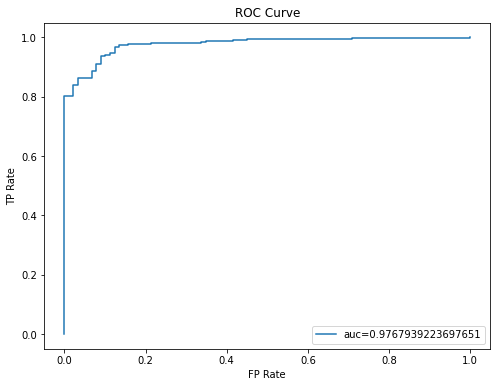

In [13]:
def plot_roc_curve(df):
    Y =  df['labels'].apply(lambda x: 0 if x[0] == 1 else 1)
    X = df.drop(columns=['labels', 'node_id'])

    clf = lr()

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.title('ROC Curve')

    plt.legend(loc=4)
    plt.savefig(f"../images/classification/roc_sizes_{FILE_NAME}.png", dpi=300)

    
if DATASET_USED == Datasets.TERR:
    plot_roc_curve(df)

In [14]:
# Extend prediction function for the OVR logistic regression model
# This code is taken from https://github.com/Kombustor/submission-ecir2020-randomwalks/blob/submission/impl/model/classify.py#L11
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        """
        return the labels with the highest k probabilities prediction, where k is the number of labels Y_test have
        """
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)

In [15]:
def evaluate(df, test_sizes, num_iter=10):
    evaluations_micro = []
    evaluations_macro = []

    Y = df['labels']
    X = df.drop(columns=['labels', 'node_id'])

    # binarize data
    binarizer = MultiLabelBinarizer()
    binarizer.fit(Y)

    # Linear regression uses L2 regularization by default
    ovr_lr =  OneVsRestClassifier(lr(solver='liblinear'))
    clf = TopKRanker(ovr_lr)

    for test_size in test_sizes:
        micro_scores = []
        macro_scores = []
        for x in range(num_iter):

            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

            Y_train = binarizer.transform(Y_train)

            top_k_list = [len(l) for l in Y_test]
            Y_test = binarizer.transform(Y_test)

            # evaluation
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test, top_k_list=top_k_list)

            micro_scores.append(f1_score(Y_test, Y_pred, average='micro', zero_division=0))
            macro_scores.append(f1_score(Y_test, Y_pred, average='macro', zero_division=0))
        
        evaluations_micro.append(sum(micro_scores)/num_iter*100)
        evaluations_macro.append(sum(macro_scores)/num_iter*100)
        print(f"Perc: {test_size}")
    return evaluations_micro, evaluations_macro

def plot_scores(micro, macro, test_size):
    fig, ax = plt.subplots(figsize=(12, 6))

    micro.reverse()
    macro.reverse()
    
    plt.plot(test_size, micro, marker='o', label='Micro F$_1$')
    plt.plot(test_size, macro, marker='o', label='Macro F$_1$')
        
    plt.xlabel("Training perc")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.savefig(f"../images/classification/test_sizes_{FILE_NAME}.png", dpi=300)

Perc: 0.1
Perc: 0.2
Perc: 0.3
Perc: 0.4
Perc: 0.5
Perc: 0.6
Perc: 0.7
Perc: 0.8
Perc: 0.9


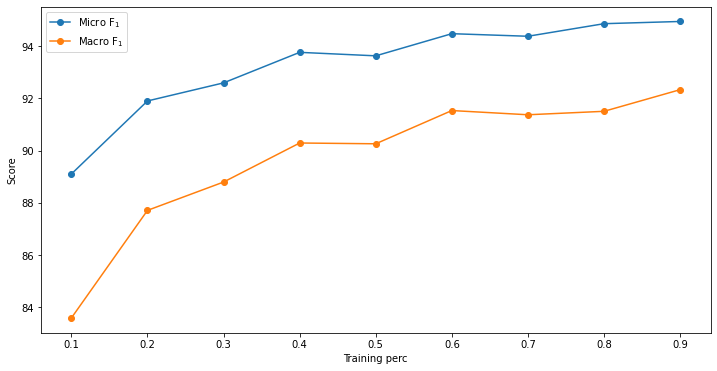

In [45]:
test_size_exp =  [x/10 for x in range(1, 10)]
micro, macro = evaluate(df, test_size_exp, 10)
plot_scores(micro, macro, test_size_exp)

# Grid search for q and p

In [16]:
import subprocess

def run_node2vec(input_file, output_file, p=1, q=1, is_weighted=False, delimiter='" "'):
    cmd = f"python main.py --p {p} --q {q} --input {input_file} --output {output_file} --delimiter {delimiter}"
    if is_weighted: cmd += " --weighted"
    subprocess.run(cmd, shell=True, stdout=subprocess.PIPE)

In [55]:
# This can be true only if the embeddings are available (generated after running a grid search once)
RUN_NODE2VEC_FOR_GRID_SEARCH = True

grid = {
    'q': [0.25, 0.50, 1, 2, 4],
    'p': [0.25, 0.50, 1, 2, 4]
}

evaluations = []

for p in grid['p']:
    for q in grid['q']:
        print(f"p: {p} q: {q}")
            
        emb_file =  f"../emb/{FILE_NAME}_q_{q}_p_{p}.emb"

        if RUN_NODE2VEC_FOR_GRID_SEARCH:
            if DATASET_USED == Datasets.PPI:
                run_node2vec(INPUT_FILE, emb_file, p, q, True)
            elif DATASET_USED == Datasets.CORA:
                run_node2vec(INPUT_FILE, emb_file, p, q, True, ",")
            elif DATASET_USED == Datasets.TERR:
                run_node2vec(INPUT_FILE, emb_file, p, q, False, ",")

        if DATASET_USED == Datasets.PPI:
            df = get_ppi_dataset(emb_file)
        if DATASET_USED == Datasets.TERR:
            df = get_cora_dataset(emb_file)
        elif DATASET_USED == Datasets.CORA:
            df = get_cora_dataset(emb_file)
            
        micro, macro = evaluate(df, [0.5])
        
        evaluations.append((q, p, micro, macro))

p: 0.25 q: 0.25
Perc: 0.5
p: 0.25 q: 0.5
Perc: 0.5
p: 0.25 q: 1
Perc: 0.5
p: 0.25 q: 2
Perc: 0.5
p: 0.25 q: 4
Perc: 0.5
p: 0.5 q: 0.25
Perc: 0.5
p: 0.5 q: 0.5
Perc: 0.5
p: 0.5 q: 1
Perc: 0.5
p: 0.5 q: 2
Perc: 0.5
p: 0.5 q: 4
Perc: 0.5
p: 1 q: 0.25
Perc: 0.5
p: 1 q: 0.5
Perc: 0.5
p: 1 q: 1
Perc: 0.5
p: 1 q: 2
Perc: 0.5
p: 1 q: 4
Perc: 0.5
p: 2 q: 0.25
Perc: 0.5
p: 2 q: 0.5
Perc: 0.5
p: 2 q: 1
Perc: 0.5
p: 2 q: 2
Perc: 0.5
p: 2 q: 4
Perc: 0.5
p: 4 q: 0.25
Perc: 0.5
p: 4 q: 0.5
Perc: 0.5
p: 4 q: 1
Perc: 0.5
p: 4 q: 2
Perc: 0.5
p: 4 q: 4
Perc: 0.5


In [56]:
# Max micro and macro scores
micro = [x[2][0] for x in evaluations]
macro = [x[3][0] for x in evaluations]

max_micro_index = micro.index(max(micro))
max_macro_index = macro.index(max(macro))

print(evaluations[max_micro_index])
print(evaluations[max_macro_index])

(0.25, 1, [21.634165589778505], [18.4528702681258])
(0.5, 2, [21.482335210050554], [18.458030958907614])


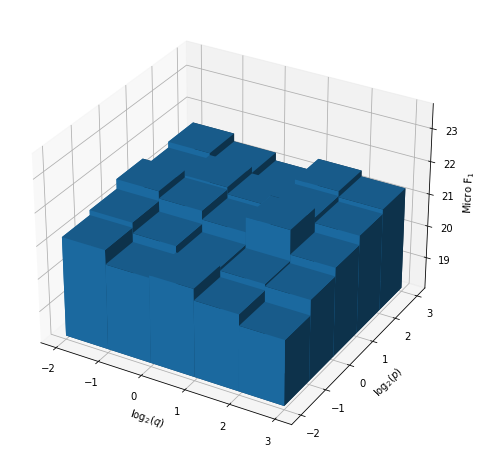

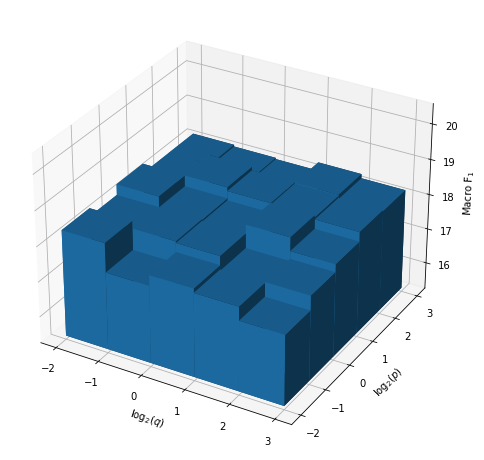

In [57]:
class Scores(Enum):
    MACRO = 1
    MICRO = 2
    
q = [np.log2(x[0]) for x in evaluations]
p = [np.log2(x[1]) for x in evaluations]
micro = [x[2][0] for x in evaluations]
macro = [x[3][0] for x in evaluations]

def plot_grid(p, q, scores, score_enum):
    q = np.array(q)
    p = np.array(p)
    scores = np.array(scores)
    
    if score_enum == Scores.MICRO:
        exp_name =  "micro_score"
        label = "Micro F$_1$"
    elif score_enum == Scores.MACRO:
        exp_name =  "macro_score"
        label = "Macro F$_1$"

    fig = plt.figure(figsize=(8, 16))
    ax = fig.add_subplot(111, projection='3d')

    
    min_lim = min(scores)-2
    max_lim = max(scores)+2
    ax.bar3d(q, p, min_lim*np.ones(len(scores)),
              1, 1, scores-min_lim)
    
    ax.set(zlim=(min_lim, max_lim))

    ax.set_xlabel('$\log_2(q)$')
    ax.set_ylabel('$\log_2(p)$')
    ax.set_zlabel(label)
    plt.savefig(f"../images/classification/grid_{exp_name}_{FILE_NAME}.png", dpi=500)

plot_grid(p, q, micro, Scores.MICRO)
plot_grid(p, q, macro, Scores.MACRO)

# Scalability (Not used in presentation)

In [6]:
import time
import networkx as nx


NODES_NUM_LIST = [10**x for x in range(2, 7)]
DEGREE = 10
wall_time_experiments = []

def export_graph(G, relative_path):
    G_int = nx.convert_node_labels_to_integers(G, first_label = 0)
    nx.readwrite.edgelist.write_edgelist(G = G_int, path = relative_path, data = False)

for nodes_num in NODES_NUM_LIST:
    G = nx.generators.random_graphs.erdos_renyi_graph(nodes_num, DEGREE/nodes_num)

    input_relative_path = f"../graph/scalability/nodesNum_{nodes_num}_scalability.edgelist"
    export_graph(G, input_relative_path)
    output_relative_path = f"../graph/scalability/nodesNum_{nodes_num}_scalability.emb"
    
    start_time = time.time()
    run_node2vec(input_relative_path, output_relative_path)
    total_time = time.time() - start_time
    
    wall_time_experiments.append(total_time)
    print(f"Wall time for {nodes_num} nodes: {total_time}")

Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]A

100%|██████████| 486/486 [00:00<00:00, 950.56it/s]


Wall time for 100 nodes: 1.1935858726501465


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s][A

100%|██████████| 4859/4859 [00:05<00:00, 966.40it/s]  


Wall time for 1000 nodes: 5.693781852722168


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s][A

100%|██████████| 50124/50124 [01:03<00:00, 795.39it/s]  


Wall time for 10000 nodes: 64.31362009048462


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]

100%|██████████| 500351/500351 [00:47<00:00, 16405.34it/s]

Wall time for 100000 nodes: 477.59348249435425


KeyboardInterrupt: 

In [ ]:
def plot_scalability_exp(nodes_num_list, wall_times):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    plt.plot(nodes_num_list, wall_times, marker='o')
        
    plt.xlabel("$\log_10$ nodes")
    plt.ylabel("time (seconds)")
    plt.savefig(f"../images/classification/scalability.png", dpi=300)
    
plot_scalability_exp(np.log(NODES_NUM_LIST), np.log(wall_time_experiments))